In [1]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD


# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [2]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [3]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [4]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [5]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [6]:
def without_news(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  #cols = ['adj_close','mean_compound']
  cols = ['adj_close']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]


  # Setting the parameters
  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
  
  # Simple RNN model
  model = Sequential()
  model.add(SimpleRNN(units = 60, activation = 'relu',return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 60,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 80, activation = 'relu',return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 120,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=15, batch_size=32)

 
  plot_training_loss(hist) 

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict[0])
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['Actual','Predicted'])
  print(df_compare)
  df_compare.plot()
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [7]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [8]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 14ms/step - loss: 0.2612 - mean_squared_error: 0.2612
Epoch 2/15
71/71 [==============================] - 1s 15ms/step - loss: 0.0964 - mean_squared_error: 0.0964
Epoch 3/15
71/71 [==============================] - 1s 13ms/step - loss: 0.0884 - mean_squared_error: 0.0884
Epoch 4/15
71/71 [==============================] - 1s 15ms/step - loss: 0.0891 - mean_squared_error: 0.0891
Epoch 5/15
71/71 [==============================] - 1s 14ms/step - loss: 0.0890 - mean_squared_error: 0.0890
Epoch 6/15
71/71 [==============================] - 1s 15ms/step - loss: 0.0825 - mean_squared_error: 0.0825
Epoch 7/15
71/71 [==============================] - 1s 14ms/step - loss: 0.0856 - mean_squared_error: 0.0856
Epoch 8/15
71/71 [==============================] - 1s 14ms/step - loss: 0.0820 - mean_squared_error: 0.0820
Epoch 9/15
71/71 [==============================] - 1s 14ms/s

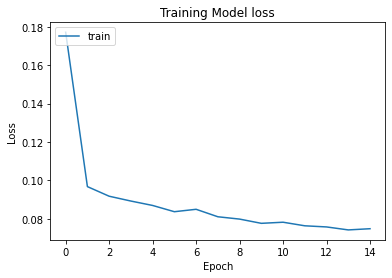

        Actual    Predicted
0    47.023903  [46.904938]
1    46.241833  [46.911964]
2    45.982750   [46.84905]
3    46.074760  [46.883434]
4    48.789028   [48.10363]
..         ...          ...
385  80.486107   [78.49709]
386  79.392090   [79.63432]
387  79.769165   [78.65439]
388  79.287888   [77.66999]
389  81.170799   [78.18042]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0730 - mean_squared_error: 0.0730
LSTM Model Loss =  [0.07298959791660309, 0.07298959791660309]
Model Accuracy =  [98.452194]
Mean Absolute Error =  0.7784954951359677  degrees
Mean Squared Error =  0.944502760147682
Root Mean Squared Error =  0.9718553185262104

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 14ms/step - loss: 0.2145 - mean_squared_error: 0.2145
Epoch 2/15
71/71 [========

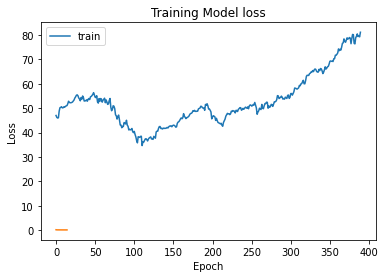

          Actual    Predicted
0    1808.000000   [1847.506]
1    1817.270020  [1841.3015]
2    1779.219971  [1813.0684]
3    1777.439941  [1812.2167]
4    1797.170044  [1827.1913]
..           ...          ...
385  2050.229980  [1994.5314]
386  2079.280029  [2019.0968]
387  2133.909912  [2066.5989]
388  2150.800049  [2080.5774]
389  2160.000000   [2090.612]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0779 - mean_squared_error: 0.0779
LSTM Model Loss =  [0.0778530016541481, 0.0778530016541481]
Model Accuracy =  [98.213585]
Mean Absolute Error =  31.18201372195513  degrees
Mean Squared Error =  1742.6094171222967
Root Mean Squared Error =  41.744573505095204

--------------------------------------------------------------------------

Evaluating Model for Company:  ADM
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 15ms/step - loss: 0.2318 - mean_squared_error: 0.2318
Epoch

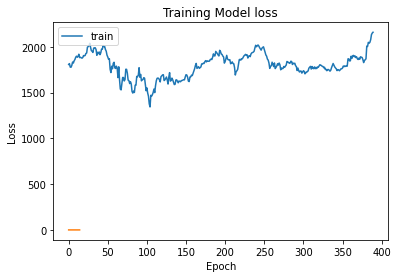

        Actual    Predicted
0    43.653885  [43.324158]
1    43.562386   [43.50237]
2    43.324490   [43.28262]
3    44.157127  [43.821075]
4    44.019875   [43.83797]
..         ...          ...
385  44.165833   [43.37731]
386  43.906483  [43.648468]
387  43.877670   [43.56472]
388  44.300312  [43.720264]
389  44.155090  [43.484406]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0783 - mean_squared_error: 0.0783
LSTM Model Loss =  [0.07834926247596741, 0.07834926247596741]
Model Accuracy =  [98.81486]
Mean Absolute Error =  0.4806717994885568  degrees
Mean Squared Error =  0.34819764516391755
Root Mean Squared Error =  0.5900827443366884

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 15ms/step - loss: 0.2834 - mean_squared_error: 0.2834
Epoch 2/15
71/71 [=======

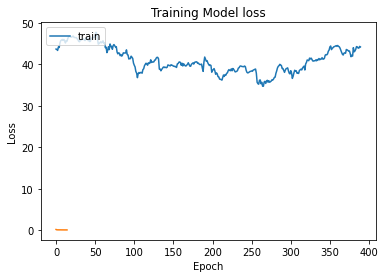

          Actual    Predicted
0    1268.329956  [1247.9817]
1    1238.500000  [1250.2048]
2    1219.739990  [1241.5825]
3    1217.260010  [1243.3958]
4    1220.010010  [1249.4993]
..           ...          ...
385  1476.229980  [1459.7306]
386  1479.229980  [1474.7734]
387  1508.680054  [1481.8862]
388  1508.790039  [1479.2609]
389  1518.270020  [1487.6091]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0840 - mean_squared_error: 0.0840
LSTM Model Loss =  [0.08399385213851929, 0.08399385213851929]
Model Accuracy =  [98.53316]
Mean Absolute Error =  17.1291250375601  degrees
Mean Squared Error =  443.4333783617006
Root Mean Squared Error =  21.057857876852065

--------------------------------------------------------------------------

Evaluating Model for Company:  EBAY
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 14ms/step - loss: 0.2130 - mean_squared_error: 0.2130
Epoch

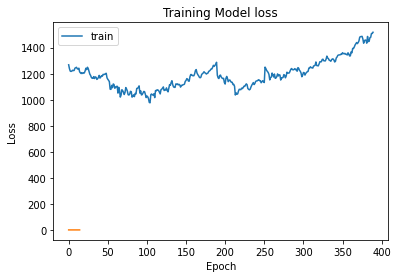

        Actual    Predicted
0    33.331360   [33.85552]
1    32.731140  [33.831608]
2    32.595608  [33.816853]
3    32.382629  [33.745132]
4    32.034122  [32.510353]
..         ...          ...
385  37.343075  [35.377342]
386  35.574196  [35.272377]
387  35.397308  [34.853676]
388  35.810051   [35.93805]
389  36.507778  [35.609566]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0730 - mean_squared_error: 0.0730
LSTM Model Loss =  [0.07298584282398224, 0.07298584282398224]
Model Accuracy =  [98.53079]
Mean Absolute Error =  0.49145368429330694  degrees
Mean Squared Error =  0.38733381868776834
Root Mean Squared Error =  0.6223614855433844

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 15ms/step - loss: 0.1989 - mean_squared_error: 0.1989
Epoch 2/15
71/71 [=======

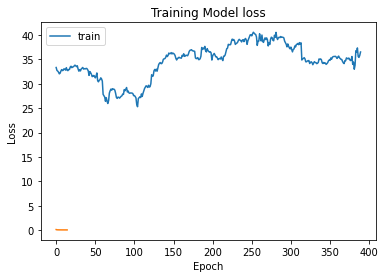

        Actual    Predicted
0    71.726852    [70.3767]
1    69.751480  [70.819046]
2    69.598213   [70.88354]
3    69.402374   [70.90008]
4    68.448746   [70.43455]
..         ...          ...
385  56.346684   [56.46627]
386  55.973351  [56.024662]
387  55.382210  [56.036217]
388  55.908691   [56.14842]
389  56.592194  [56.018406]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0823 - mean_squared_error: 0.0823
LSTM Model Loss =  [0.08228032290935516, 0.08228032290935516]
Model Accuracy =  [98.71703]
Mean Absolute Error =  0.8406620514698517  degrees
Mean Squared Error =  1.111971061834573
Root Mean Squared Error =  1.0545003849380867

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (390, 1)
Epoch 1/15
71/71 [==============================] - 4s 15ms/step - loss: 0.2327 - mean_squared_error: 0.2327
Epoch 2/15
71/71 [==========

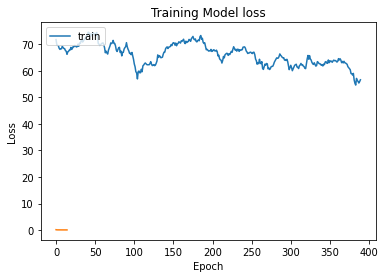

        Actual    Predicted
0    63.071827  [61.955677]
1    62.687599  [62.267666]
2    62.601139  [62.479073]
3    62.956558  [61.712963]
4    62.226517  [62.419003]
..         ...          ...
385  88.100525   [86.62857]
386  86.525017   [86.41002]
387  86.948433  [86.405785]
388  87.805115   [86.50702]
389  87.430931   [86.50146]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0965 - mean_squared_error: 0.0965
LSTM Model Loss =  [0.09650682657957077, 0.09650682657957077]
Model Accuracy =  [98.697174]
Mean Absolute Error =  0.9721049479949168  degrees
Mean Squared Error =  1.4583108510090352
Root Mean Squared Error =  1.207605420246628

--------------------------------------------------------------------------



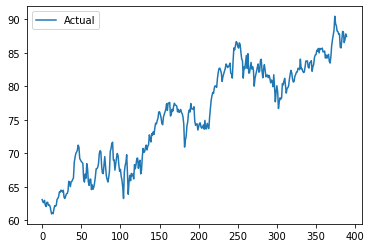

In [9]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = without_news(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)

In [13]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.778495,0.944503,[98.452194],0.971855
1,AMZN,31.182014,1742.609417,[98.213585],41.744574
2,ADM,0.480672,0.348198,[98.81486],0.590083
3,GOOG,17.129125,443.433378,[98.53316],21.057858
4,EBAY,0.491454,0.387334,[98.53079],0.622361
5,XOM,0.840662,1.111971,[98.71703],1.054500
6,ABT,0.972105,1.458311,[98.697174],1.207605


In [14]:
# Mean Accuracy for DP-LSTM
mean_results = company_results.mean(axis = 0)
mean_results

MAE            7.41065
MSE            312.899
Accuracy    [98.56554]
RMSE           9.60698
dtype: object

In [15]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P13_RNN_All_Companies_without_news"+current_time+".csv"
company_results.to_csv(name)